In [2]:
from pathlib import Path
import os
import random

from sqlalchemy.orm.session import Session
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, text, inspect
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Contrib.SA_Score.sascorer import calculateScore
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec

## Load Sql Data
Use this script to load and analyse the data after running the example scripts (example.py) in the previous folder.

In [3]:
path = Path.cwd() /'..' 

runs = [str(x) for x in path.glob('**/*.sqlite') if 'run' in str(x)]
runs

['/data/chureh/pvfsga_analysis/dummy_example/post-processing/../fake_run/run_1.sqlite']

In [4]:
dfs = []
fps = []
for run in runs:
    rop_class = run.split('/')[-2]
    db_server = (
        f"sqlite:///{str(run)}"
    )
    engine = create_engine(db_server)
    query = '''select 
        m.smiles as molecule_smiles,
        s.structure,
        rg.smiles as rgroup,
        m.molecule_id,
        rg.rgroup_id,
        s.scaffold_id,
        rgm.[index] as rgroup_location
    from molecules m
    join scaffolds s on s.scaffold_id == m.scaffold_id
    join rgroup_mappings rgm on rgm.molecule_id == m.molecule_id
    join rgroups rg on rg.rgroup_id == rgm.rgroup_id
    '''
    rgroups = pd.read_sql(text(query), engine.connect())
    rgroups = rgroups.pivot_table(values=['rgroup'], columns=['rgroup_location'], index=['molecule_smiles', 'structure', 'molecule_id', 'scaffold_id'], aggfunc=lambda x: ' '.join(x))
    rgroups.columns = rgroups.columns.droplevel(0)
    rgroups.columns.name = None 
    rgroups= rgroups.reset_index()
    
    query = '''select 
        rpm.molecule_id,
        p.smiles,
        p.canonical_smiles,
        pp.prop,
        pp.prop_unit,
        pp.value,
        pg.generation
        from polymer_properties pp
        join polymers p on pp.pol_id = p.pol_id
        join polymer_generation pg on pg.pol_id = p.pol_id
        join reaction_polymer_mappings rpm on rpm.pol_id = p.pol_id
    '''
    df = pd.read_sql(text(query), engine.connect())
    df['rop_class'] = rop_class
    normalized_path = os.path.normpath(run)

    # Extract the base name (the last part of the path)
    base_name = os.path.basename(normalized_path)
    
    # Remove the file extension to get the desired string
    run_name = os.path.splitext(base_name)[0]
    df['run_name'] = run_name
    df = df.pivot_table(values=['value'], columns=['prop'], index=['molecule_id', 'smiles', 'canonical_smiles', 'generation', 'rop_class','run_name'])
    df.columns = df.columns.droplevel(0)
    df.columns.name = None 
    df = df.reset_index()
    df = df.merge(rgroups, on='molecule_id')
    dfs.append(df.copy())

    query = '''select p.smiles, pf.key, pf.value from polymer_fingerprints pf
    join polymers p on p.pol_id = pf.pol_id
    '''
    
    fp = pd.read_sql(text(query), engine.connect())
    fp = fp.pivot_table(columns='key', values='value', index='smiles')
    fp.columns.name = None 
    fp = fp.reset_index().fillna(0)
    fps.append(fp.copy())
df = pd.concat(dfs)
df = df.reset_index(drop=True)
df['sa_score'] = df['sa_score'] * -1
df = df.drop_duplicates(subset='canonical_smiles').reset_index().fillna(0)
fp = pd.concat(fps)
fp = fp.drop_duplicates(subset='smiles').reset_index().fillna(0)
fp = fp.reset_index(drop=True)

## Draw the Scaffolds 

In [5]:
scaffolds = df[['rop_class', 'structure', 'scaffold_id']].drop_duplicates()
opts = Draw.MolDrawOptions()
opts.bondLineWidth = 5.
opts.minFontSize = 40
for index, row in scaffolds.iterrows():
    folder = Path('scaffolds') / row['rop_class']
    folder.mkdir(parents=True, exist_ok=True)
    m = Chem.MolFromSmiles(row['structure'])
    img = Draw.MolToImage(m, size=(400, 400))
    gimg = img.convert('L')
    width, height = gimg.size
    left, top, right, bottom = width, height, 0, 0
    for x in range(width):
        for y in range(height):
            if gimg.getpixel((x, y)) < 255:  # Check if pixel is not white
                left = min(left, x)
                right = max(right, x)
                top = min(top, y)
                bottom = max(bottom, y)

    # Crop the image using the bounding box
    cropped_img = img.crop((left, top, right + 1, bottom + 1))
    cropped_img.save(str(folder / f"scaffold_{row['scaffold_id']}.png"))

In [6]:
scaffolds

,rop_class,structure,scaffold_id
0,fake_run,[*:1]C1C=CC([*:2])C1,1
1,fake_run,[*:1]C1([*:2])CC2C=CC1C2,2
2,fake_run,[*:1]C1C2C=CC(C2)C1[*:2],3


## Plot Evolution

In [9]:
properties_target = {
    "sa_score": {"target": -3, "cap": False},
    "fake_Tg": {"target": 373, "cap": False},
    "fake_dH_eff": {"target": 10, "cap": False},
} # Dictionary that contains the property name, target, and whether the property should be above or below the target value

order = ["fake_run"]
df_parents  = pd.DataFrame()
list_min_max = []
for rop in order:
    dict_min_max = {}
    dict_min_max["rop_class"] = rop
    temp_df = df.loc[df.rop_class==rop]
    for gen in range (1, df['generation'].max()+1):
        dict_min_max["generation"] = gen

        df_gen = temp_df.loc[temp_df.generation == gen]
        sorted_df = df_gen.sort_values(by='fitness', ascending=False)
        df_parents_per_gen = sorted_df.head(50)
        #print(df_parents_per_gen)
        df_parents = pd.concat([df_parents, df_parents_per_gen])
        for prop,dict in properties_target.items():
            dict_min_max["prop"] = prop
            dict_min_max["min"] = df_parents_per_gen[prop].min()
            dict_min_max["max"] = df_parents_per_gen[prop].max()
            #print(dict_min_max)
            list_min_max.append(dict_min_max.copy())
            #(list_min_max)


df_min_max = pd.DataFrame(list_min_max)
df_min_max

,rop_class,generation,prop,min,max
0,fake_run,1,sa_score,4.465226,6.677366
1,fake_run,1,fake_Tg,146.827171,338.154250
2,fake_run,1,fake_dH_eff,7.348557,10.000000
3,fake_run,2,sa_score,4.293448,5.907466
4,fake_run,2,fake_Tg,219.306284,313.860723
...,...,...,...,...,...
115,fake_run,39,fake_Tg,206.170837,257.187761
116,fake_run,39,fake_dH_eff,10.000000,10.000000
117,fake_run,40,sa_score,6.288384,6.288384
118,fake_run,40,fake_Tg,212.486669,212.486669


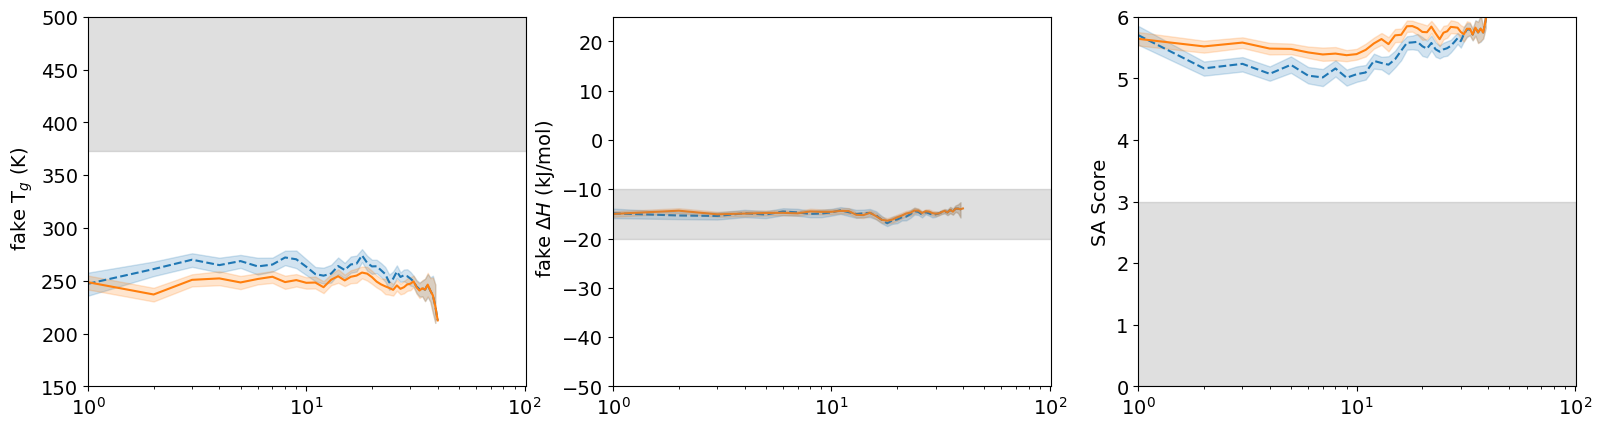

In [12]:
plt.close('all')
properties_target = {
    "sa_score": {"target": -3, "cap": False},
    "fake_Tg": {"target": 373, "cap": False},
    "fake_dH_eff": {"target": 10, "cap": False},}


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3*6.4, 1*4.8))
props = ['fake_Tg', 'fake_dH', 'sa_score']
labels = {
    'fake_Tg': ' fake T$_{g}$ (K)',
    'fake_dH': ' fake $\Delta H$ (kJ/mol)',
    'sa_score': 'SA Score'
}
target_area = {
    'fake_Tg': [373, 2000],
    'fake_dH': [-10, -20],
    'sa_score':[0,3]
}
graph_area_1 = {
    'fake_Tg': [150, 500],
    'fake_dH': [-50, 25],
    'sa_score':[0,6]
}

axes = axes.flatten()
min_max = {}
for i in range(3):
    ax = axes[i]
    prop = props[i]
    #graph_area = [df[prop].min(), df[prop].max()]
    graph_area = graph_area_1[prop]
    if prop =="sa_score":
        graph_area = [0,6]
    area = target_area[prop]
    legend = False

    if i == 2:
        legend = False

    ax1 = sns.lineplot(data=df_parents, x='generation', y=prop,errorbar=('ci', 95), ax=ax, legend = False)
    
    lines = ax1.get_lines()
    #print(lines)
    for line in lines:
        line.set_linestyle("--")
        ax1.get_lines()
    ax2 = sns.lineplot(data=df, x='generation', y=prop , errorbar=('ci', 95), ax=ax, legend = legend)
               
    if i == 2:
        print()
    ax.set_ylabel(labels[prop], fontsize = 14)
    ax.fill_between(range(0, 102), area[0], area[1], alpha=0.25, color='grey', zorder=2)
    ax.set_xscale('log')
    ax.set_xlim([1, 101])
    ax.set_ylim(graph_area)
    if i > 2:
        ax.set_xlabel('Generation', fontsize = 14)
    else:
        ax.set_xlabel('')
    ax.tick_params(axis='both', which='major', labelsize=14)

#fig.savefig('evolution_of_props_sa.png', dpi=1000, bbox_inches='tight')

## Universal Fitness Calculation and Plots

In [13]:
min_dict = {"sa_score":min(df["sa_score"]),	"fake_Tg":min(df["fake_Tg"]),	"fake_dH_eff":min(df["fake_dH_eff"])}
max_dict = {"sa_score":-3,	"fake_Tg":373,	"fake_dH_eff":10}


    
print(min_dict, max_dict)

polymer_fitness = {}
prog = 0

for index, row in df.iterrows():
    fitness = 0
    for key,value in min_dict.items():
        fitness = fitness+ (min([row[key],max_dict[key]]) - value)/(max_dict[key] - value)
    
    fitness = fitness/len(min_dict)
    polymer_fitness[row['canonical_smiles']] = fitness
    #if fitness >=1:
        #print(row['smiles'])
df["universal_fitness"] = polymer_fitness.values()



{'sa_score': 3.7690550760827666, 'fake_Tg': 124.44444262304654, 'fake_dH_eff': 6.856687106991369} {'sa_score': -3, 'fake_Tg': 373, 'fake_dH_eff': 10}


/tmp/ipykernel_2192364/2229953279.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='universal_fitness' ,palette='colorblind',legend=True, binwidth=0.0025)


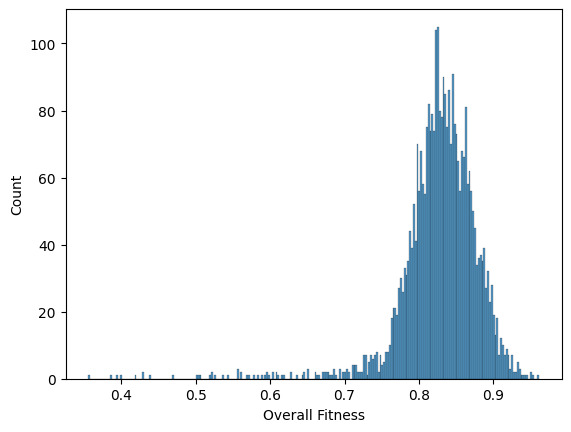

In [14]:
sns.histplot(data=df, x='universal_fitness' ,palette='colorblind',legend=True, binwidth=0.0025)
plt.xlabel("Overall Fitness")
plt.savefig("fitness_count.png",bbox_inches='tight', dpi=1000)
plt.show()

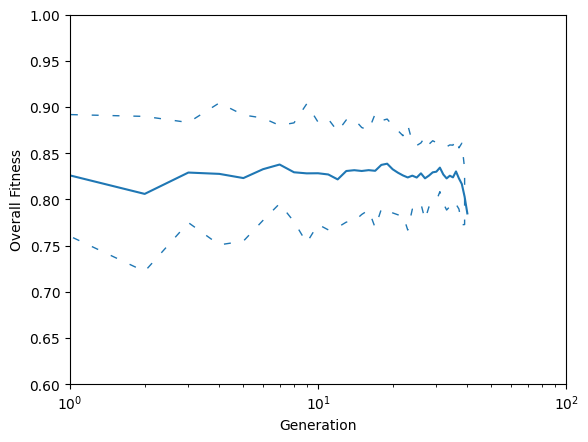

In [15]:
plt.close('all')
fig = plt.figure(figsize=(1*6.4, 1*4.8))
sns.lineplot(data=df, x='generation', y='universal_fitness', errorbar=('sd'), legend = False,
            err_kws={'dashes': (0, (5, 10)), 'facecolor': 'none', 'alpha': 1})


plt.xscale('log')
plt.xlabel('Generation')
plt.ylabel('Overall Fitness')
plt.ylim([0.6, 1])
plt.xlim([1, 100])
plt.savefig("generation_evolution_sa.png",  bbox_inches='tight', dpi=1000)

## Rgroup Analysis

In [16]:
rgroup_counts = {}
all_rgroups = pd.read_csv(path / 'small_rgroups.csv')
order = ["fake_run"]
for class_ in order:
    rgroup_counts[class_] = {}
    for index, row in all_rgroups.iterrows():
        rgroup_counts[class_][row['rgroups']] = 0
for class_ in order:
    for i in [1, 2]:
        tdf = df.loc[df.rop_class == class_]
        vc = tdf[i].value_counts().to_dict()
        for k, v in vc.items():
            if k not in rgroup_counts[class_]:
                rgroup_counts[class_][k] = 0
            rgroup_counts[class_][k] += v
data = []
for rop_class, counts in rgroup_counts.items():
    for k, v in counts.items():
        data.append({
            'rgroup': k,
            'count': v,
            'rop_class': rop_class
        })
rgroup_counts = pd.DataFrame(data)


/tmp/ipykernel_2192364/3339247862.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df, x='universal_fitness', palette='colorblind', multiple="stack", legend=False, binwidth=0.0025, ax=ax)


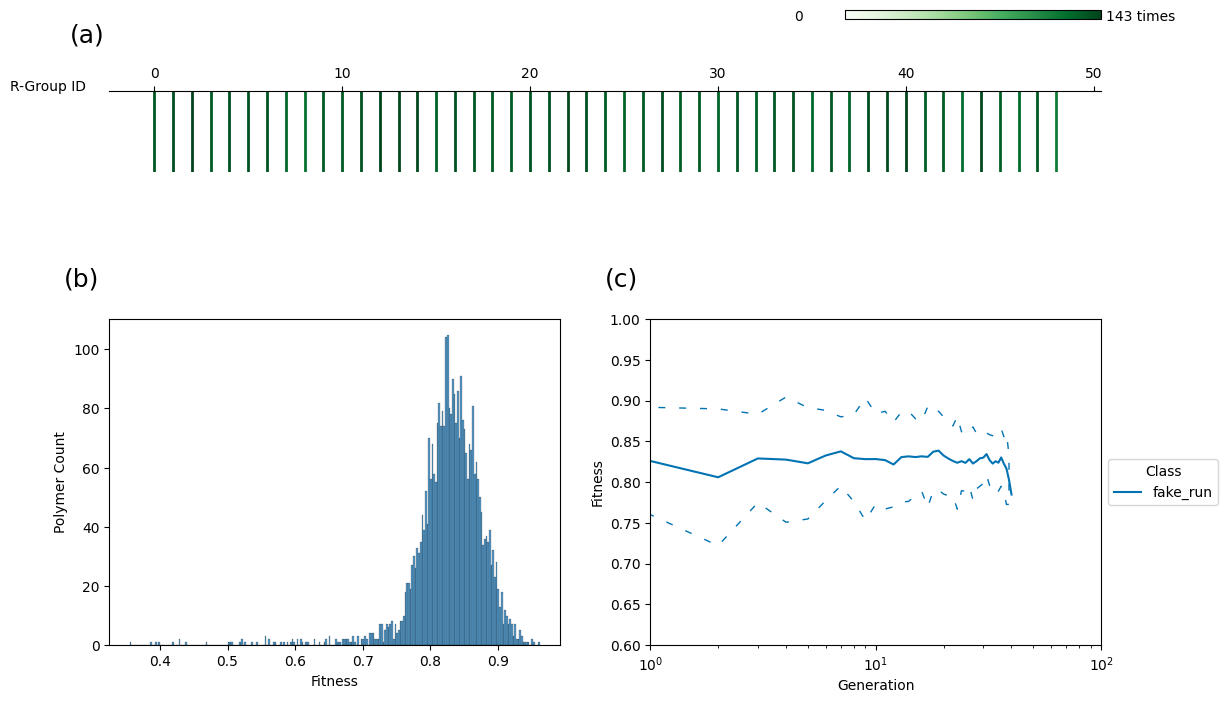

In [17]:
plt.close('all')
gs = GridSpec(3, 2, height_ratios=[1, 1, 4])
fig = plt.figure(figsize=(2*6.4, 1.5*4.8))
axes = [fig.add_subplot(gs[0, :]), fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])]
ax = axes[2]
sns.lineplot(data=df, x='generation', y='universal_fitness', hue='rop_class', palette='colorblind', errorbar=('sd'), ax=ax,
            err_kws={'dashes': (0, (5, 10)), 'facecolor': 'none', 'alpha': 1})
ax.set_xscale('log')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')
ax.set_ylim([0.6, 1])
ax.set_xlim([1, 100])
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5), title='Class')
ax.text(-0.1, 1.1, f'(c)', fontsize=18, transform=ax.transAxes)

ax = axes[1]
sns.histplot(df, x='universal_fitness', palette='colorblind', multiple="stack", legend=False, binwidth=0.0025, ax=ax)
ax.set_xlabel('Fitness')
ax.set_ylabel('Polymer Count')
ax.text(-0.1, 1.1, f'(b)', fontsize=18, transform=ax.transAxes)

# Create a figure and axis
ax = axes[0]
# Define colors for different expression levels
tdf = rgroup_counts.groupby('rgroup')['count'].sum().reset_index()
tdf = tdf.iloc[1:, :]
start_count = 0
tdf_focus = tdf.loc[tdf['count'] > start_count].reset_index()
color_map = plt.cm.Greens  # Choose your colormap
expression_levels = np.linspace(0, 1, num=256)
colors = color_map(expression_levels)
max_ = tdf_focus['count'].max()
new_index = []
for index, row in tdf_focus.iterrows():
    ax.vlines(x=index, ymin=0, ymax=1, color=colors[int(row['count'] / max_ * 255)], linewidth=2)
#ax.set_xlim([-5, tdf_focus.index.max() + 5])
ax.set_ylim([0, 1])
ax.set_yticks([])
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax.set_xlabel('')
ax.text(-0.1, 1, f'R-Group ID', transform=ax.transAxes)

cax = fig.add_axes([0.7, 0.98, 0.2, 0.0125])
sm = ScalarMappable(cmap=color_map)
sm.set_array([int(x / max_ * 255) for x in tdf_focus['count']])
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('')
cbar.set_ticks([])
ax.text(0.69, 1.86, f'{start_count}', transform=ax.transAxes)
ax.text(1.005, 1.86, f'{max_} times', transform=ax.transAxes)
ax.text(-.04, 1.6, f'(a)', fontsize=18, transform=ax.transAxes)
plt.savefig("rgroups_anal.png")

## Synthesizability Analysis

In [18]:
df['sa_score'] = df.molecule_smiles.apply(lambda smiles: calculateScore(Chem.MolFromSmiles(smiles)))

<Axes: xlabel='sa_score', ylabel='Count'>

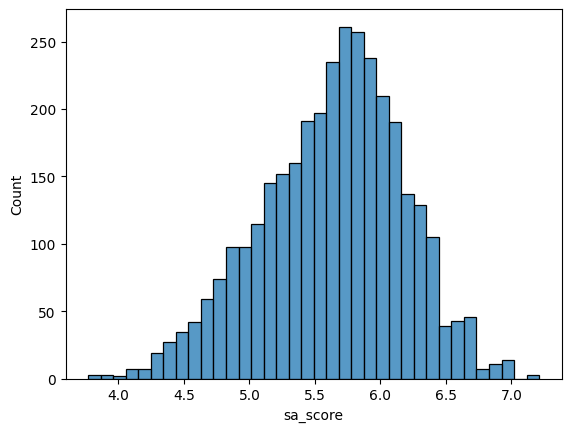

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1*6.4, 1*4.8))
sns.histplot(df, x='sa_score', ax=ax)